In [1]:
from __future__ import print_function
import argparse
import torch
from torch.utils import data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

%matplotlib inline
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np


from sklearn.manifold import TSNE
from random import random
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans

import math

import os
from PIL import Image
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable


import glob
import torchvision.transforms as transforms
import torchvision
from sklearn.model_selection import train_test_split
import pickle

In [2]:

take_latent_max =10
num_epoch = 10
input_dim=28*28
output_dim=input_dim


K_model_cluster = 10
K_real_cluster = 10

beta= 1.0
beta_start = beta
beta_end = 5.0
total_step = 500
beta_delta = (beta_end-beta_start)/total_step

save_folder = './gmm-resnet-results/images/'


KMeans_random_state = 1 #(random seed)
Gaussian_random_state = 1  #(random seed)

eps_N_c = 0
iter_adiabatic =1

alpha_0 = 10.

mu_c_focus = 0.5

stabilizer_eps = 1.0e-16

# EncoderCNN architecture
CNN_fc_hidden1, CNN_fc_hidden2 = 1024, 1024
CNN_embed_dim = 10     # latent dim extracted by 2D CNN
res_size = 224        # ResNet image size
dropout_p = 0.2       # dropout probability

# training parameters
epochs = 20        # training epochs
batch_size = 50
learning_rate = 1e-3
log_interval = 200   # interval for displaying training info


# save model
save_model_path = './gmm-resnet-results/model/'


def check_mkdir(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)


def loss_function(recon_x, x, mu, logvar):
    # MSE = F.mse_loss(recon_x, x, reduction='sum')
    MSE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + beta*KLD

In [3]:
def loss_function_c(recon_x,x,mus_f,logvars_f,mu_c_f,logvar_c_f,log_N_k_f):
    BCE = F.binary_cross_entropy(recon_x,x,reduction='sum')
    KLD = -0.5*(1+logvars_f).sum() -((((-0.5*((logvar_c_f+(logvars_f.exp()+(mus_f-mu_c_f).pow(2))/(logvar_c_f.exp())).sum(1,keepdim=True))+torch.digamma(alpha_0 + log_N_k_f.exp()) - torch.digamma(K_model_cluster*alpha_0+log_N_k_f.exp().sum(2,keepdim = True))).exp()).sum(2,keepdim=True)+stabilizer_eps).log()).sum() + ((log_N_k_f.exp())*(torch.digamma(alpha_0 + log_N_k_f.exp()) - torch.digamma(K_model_cluster*alpha_0+log_N_k_f.exp().sum(2,keepdim = True)))).sum(2).squeeze() + torch.lgamma(K_model_cluster*alpha_0+log_N_k_f.exp().sum(2).squeeze()) - (torch.lgamma(alpha_0 + log_N_k_f.exp())).sum(2).squeeze()#+(logvars_f.exp()+(mus_f-mu_c_f).pow(2))/(logvar_c_f.exp()))

    return BCE+beta*KLD

In [4]:
class Dataset(data.Dataset):
    "Characterizes a dataset for PyTorch"
    def __init__(self, filenames, labels, transform=None):
        "Initialization"
        self.filenames = filenames
        self.labels = labels
        self.transform = transform

    def __len__(self):
        "Denotes the total number of samples"
        return len(self.filenames)


    def __getitem__(self, index):
        "Generates one sample of data"
        # Select sample
        filename = self.filenames[index]
        X = Image.open(filename)

        if self.transform:
            X = self.transform(X)     # transform

        y = torch.LongTensor([self.labels[index]])
        return X, y
## ---------------------- end of Dataloaders ---------------------- ##

def conv2D_output_size(img_size, padding, kernel_size, stride):
    # compute output shape of conv2D
    outshape = (np.floor((img_size[0] + 2 * padding[0] - (kernel_size[0] - 1) - 1) / stride[0] + 1).astype(int),
                np.floor((img_size[1] + 2 * padding[1] - (kernel_size[1] - 1) - 1) / stride[1] + 1).astype(int))
    return outshape

def convtrans2D_output_size(img_size, padding, kernel_size, stride):
    # compute output shape of conv2D
    outshape = ((img_size[0] - 1) * stride[0] - 2 * padding[0] + kernel_size[0],
                (img_size[1] - 1) * stride[1] - 2 * padding[1] + kernel_size[1])
    return outshape


In [5]:
## ---------------------- ResNet VAE ---------------------- ##

class ResNet_VAE(nn.Module):
    def __init__(self, fc_hidden1=1024, fc_hidden2=768, drop_p=0.3, CNN_embed_dim=256):
        super(ResNet_VAE, self).__init__()

        self.fc_hidden1, self.fc_hidden2, self.CNN_embed_dim = fc_hidden1, fc_hidden2, CNN_embed_dim

        # CNN architechtures
        self.ch1, self.ch2, self.ch3, self.ch4 = 16, 32, 64, 128
        self.k1, self.k2, self.k3, self.k4 = (5, 5), (3, 3), (3, 3), (3, 3)      # 2d kernal size
        self.s1, self.s2, self.s3, self.s4 = (2, 2), (2, 2), (2, 2), (2, 2)      # 2d strides
        self.pd1, self.pd2, self.pd3, self.pd4 = (0, 0), (0, 0), (0, 0), (0, 0)  # 2d padding

        # encoding components
        #resnet = models.resnet152(pretrained=True)
#        resnet = models.resnet18(pretrained=True)
#        resnet = models.resnet50(pretrained=True)
        resnet = models.resnet101(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.fc1 = nn.Linear(resnet.fc.in_features, self.fc_hidden1)
        self.bn1 = nn.BatchNorm1d(self.fc_hidden1, momentum=0.01)
        self.fc2 = nn.Linear(self.fc_hidden1, self.fc_hidden2)
        self.bn2 = nn.BatchNorm1d(self.fc_hidden2, momentum=0.01)
        # Latent vectors mu and sigma
        self.fc3_mu = nn.Linear(self.fc_hidden2, self.CNN_embed_dim)      # output = CNN embedding latent variables
        self.fc3_logvar = nn.Linear(self.fc_hidden2, self.CNN_embed_dim)  # output = CNN embedding latent variables

        # Sampling vector
        self.fc4 = nn.Linear(self.CNN_embed_dim, self.fc_hidden2)
        self.fc_bn4 = nn.BatchNorm1d(self.fc_hidden2)
        self.fc5 = nn.Linear(self.fc_hidden2, 64 * 4 * 4)
        self.fc_bn5 = nn.BatchNorm1d(64 * 4 * 4)
        self.relu = nn.ReLU(inplace=True)

        # Decoder
        self.convTrans6 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=self.k4, stride=self.s4,
                               padding=self.pd4),
            nn.BatchNorm2d(32, momentum=0.01),
            nn.ReLU(inplace=True),
        )
        self.convTrans7 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=8, kernel_size=self.k3, stride=self.s3,
                               padding=self.pd3),
            nn.BatchNorm2d(8, momentum=0.01),
            nn.ReLU(inplace=True),
        )

        self.convTrans8 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=self.k2, stride=self.s2,
                               padding=self.pd2),
            nn.BatchNorm2d(3, momentum=0.01),
            nn.Sigmoid()    # y = (y1, y2, y3) \in [0 ,1]^3
        )


    def encode(self, x):
        x = self.resnet(x)  # ResNet
        x = x.view(x.size(0), -1)  # flatten output of conv

        # FC layers
        x = self.bn1(self.fc1(x))
        x = self.relu(x)
        x = self.bn2(self.fc2(x))
        x = self.relu(x)
        # x = F.dropout(x, p=self.drop_p, training=self.training)
        mu, logvar = self.fc3_mu(x), self.fc3_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        x = self.relu(self.fc_bn4(self.fc4(z)))
        x = self.relu(self.fc_bn5(self.fc5(x))).view(-1, 64, 4, 4)
        x = self.convTrans6(x)
        x = self.convTrans7(x)
        x = self.convTrans8(x)
        x = F.interpolate(x, size=(224, 224), mode='bilinear')
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_reconst = self.decode(z)

        return x_reconst, z, mu, logvar

In [6]:

# Detect devices
use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU

# Data loading parameters
params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 4, 'pin_memory': True} if use_cuda else {}
transform = transforms.Compose([transforms.Resize([res_size, res_size]),
                                transforms.ToTensor(),
                                transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # gray -> GRB 3 channel (lambda function)
                                transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])])  # for grayscale images

# MNIST dataset (images and labels)
MNIST_train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
MNIST_test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)

# Data loader (input pipeline)
train_loader = torch.utils.data.DataLoader(dataset=MNIST_train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=MNIST_test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
valid_loader.batch_size,device

(50, device(type='cuda'))

In [8]:
# Create model
resnet_vae = ResNet_VAE(fc_hidden1=CNN_fc_hidden1, fc_hidden2=CNN_fc_hidden2, drop_p=dropout_p, CNN_embed_dim=CNN_embed_dim).to(device)

In [9]:
mu_c_focus = 1.0
def initialize_centers():

    mu_c = mu_c_focus*torch.randn(1,CNN_embed_dim,K_model_cluster,device=device)
    logvar_c = torch.zeros(1,CNN_embed_dim,K_model_cluster).to(device)
    log_N_k = torch.zeros(1,1,K_model_cluster).to(device)

    return mu_c,logvar_c, log_N_k

In [10]:
#zs_g,ts_g,mus_g,logvars_g = take_latents()
mu_c_g,logvar_c_g,log_N_k_g = initialize_centers()
#mu_c_g,logvar_c_g,pi_c_g,Q_c_g,gamma_c_g,log_P_g = gauss(mus_g,logvars_g,mu_c_g,logvar_c_g,pi_c_g,50)
mu_c_g.shape,logvar_c_g.shape,log_N_k_g.shape
#mu_c_g,logvar_c_g,pi_c_g,Q_c_g,gamma_c_g,log_P_g = gauss(mus_g,logvars_g,mu_c_g,logvar_c_g,pi_c_g,50)

(torch.Size([1, 10, 10]), torch.Size([1, 10, 10]), torch.Size([1, 1, 10]))

In [11]:
mu_c_g.requires_grad_(True)
logvar_c_g.requires_grad_(True)
log_N_k_g.requires_grad_(True)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], device='cuda:0',
       requires_grad=True)

In [12]:
mu_c_g.requires_grad,logvar_c_g.requires_grad,log_N_k_g.requires_grad
#F.softmax(inv_sm_pi_c_g,dim=0)

(True, True, True)

In [13]:
print("Using", torch.cuda.device_count(), "GPU!")
model_params = list(resnet_vae.parameters())
optimizer = torch.optim.Adam(model_params, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[20,40,60,80,100,120,140,160,180,200,220,240,260],gamma=0.9)

optimizer_clustering = optim.Adam([mu_c_g,logvar_c_g,log_N_k_g],lr=0.002)
scheduler_clustering = torch.optim.lr_scheduler.MultiStepLR(optimizer_clustering,milestones=[20,40,60,80,100,120,140,160,180,200,220,240,260],gamma=0.9)


Using 1 GPU!


In [14]:

def train(log_interval, model, device, train_loader, optimizer, epoch):
    # set model as training mode
    model.train()

    losses = []
    all_y, all_z, all_mu, all_logvar = [], [], [], []
    N_count = 0   # counting total trained sample in one epoch
    for batch_idx, (X, y) in enumerate(train_loader):
        # distribute data to device
        X, y = X.to(device), y.to(device).view(-1, )
        N_count += X.size(0)

        optimizer.zero_grad()
        X_reconst, z, mu, logvar = model(X)  # VAE
        loss = loss_function(X_reconst, X, mu, logvar)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

        all_y.extend(y.data.cpu().numpy())
        all_z.extend(z.data.cpu().numpy())
        all_mu.extend(mu.data.cpu().numpy())
        all_logvar.extend(logvar.data.cpu().numpy())

        # show information
        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, N_count, len(train_loader.dataset), 100. * (batch_idx + 1) / len(train_loader), loss.item()))

    all_y = np.stack(all_y, axis=0)
    all_z = np.stack(all_z, axis=0)
    all_mu = np.stack(all_mu, axis=0)
    all_logvar = np.stack(all_logvar, axis=0)

    # save Pytorch models of best record
    torch.save(model.state_dict(), os.path.join(save_model_path, 'model_epoch{}.pth'.format(epoch + 1)))  # save motion_encoder
    torch.save(optimizer.state_dict(), os.path.join(save_model_path, 'optimizer_epoch{}.pth'.format(epoch + 1)))      # save optimizer
    print("Epoch {} model saved!".format(epoch + 1))

    return X.data.cpu().numpy(), all_y, all_z, all_mu, all_logvar, losses


In [15]:
def train_c(log_interval, model, device, train_loader, optimizer, epoch,mu_c,logvar_c,log_N_k):
    model.train()
    train_loss = 0
    for batch_idx, (data,_) in enumerate(train_loader):
        #ラベルは使わないようだ
        data = data.to(device)
        #データをGPUにおくる
        optimizer.zero_grad()
        optimizer_clustering.zero_grad()
        #傾きの初期化
        recon_batch, z,mu, logvar = model(data)
        #VAEからバッヂ分のデータと中心と分散のログを受け取る

        loss = loss_function_c(recon_x=recon_batch,x=data,mus_f=mu.view(-1,CNN_embed_dim,1),logvars_f=logvar.view(-1,CNN_embed_dim,1),mu_c_f=mu_c,logvar_c_f=logvar_c,log_N_k_f=log_N_k)
        #バッヂ分のロスを計算。バッヂ数で割っていないようだ。書き出しのときにデータ数で割っている。
        loss.backward()
        #傾きを計算
        train_loss+= loss.item()
        optimizer.step()
        #NNパラメータの更新

        optimizer_clustering.step()
        #NNクラスタリングパラメータの更新


        if batch_idx % log_interval ==0:
            #一定間隔でロスを書き出し。epochはここでしか使っていないようだ。len()は最初の次元の大きさを出すのでバッヂの大きさ。
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch,batch_idx*len(data),len(train_loader.dataset),
                100.*batch_idx/len(train_loader),
                loss.item()/len(data)
            ))

    torch.save(model.state_dict(), os.path.join(save_model_path, 'model_epoch{}.pth'.format(epoch + 1)))  # save motion_encoder
    torch.save(optimizer.state_dict(), os.path.join(save_model_path, 'optimizer_epoch{}.pth'.format(epoch + 1)))      # save optimizer
    print("Epoch {} model saved!".format(epoch + 1))


In [16]:
def validation(model, device, optimizer, test_loader):
    # set model as testing mode
    model.eval()
#   model.train()

    test_loss = 0
    all_y, all_z, all_mu, all_logvar = [], [], [], []
    with torch.no_grad():
#        for X, y in test_loader:
        for i, (X, y) in enumerate(test_loader):
            # distribute data to device
            X, y = X.to(device), y.to(device).view(-1, )
            X_reconst, z, mu, logvar = model(X)

            loss = loss_function(X_reconst, X, mu, logvar)
            test_loss += loss.item()  # sum up batch loss

            all_y.extend(y.data.cpu().numpy())
            all_z.extend(z.data.cpu().numpy())
            all_mu.extend(mu.data.cpu().numpy())
            all_logvar.extend(logvar.data.cpu().numpy())

            if i == 0:
                #はじめのバッヂについて
                n = min(X.size(0),8)
                #nをバッヂのデータ数か８との小さい方として
                comparizon = torch.cat([X[:n],X_reconst.view(batch_size,3,res_size,res_size)[:n]])
                #元データと再現データを並べる
                save_image(comparizon.cpu(),'./'+save_folder+'/reconstruction_c_' + str(epoch) + '.png',nrow=n)


    test_loss /= len(test_loader.dataset)
    all_y = np.stack(all_y, axis=0)
    all_z = np.stack(all_z, axis=0)
    all_mu = np.stack(all_mu, axis=0)
    all_logvar = np.stack(all_logvar, axis=0)

    # show information
    print('\nTest set ({:d} samples): Average loss: {:.4f}\n'.format(len(test_loader.dataset), test_loss))
    return X.data.cpu().numpy(), all_y, all_z, all_mu, all_logvar, test_loss

In [17]:
def test_c(model, device, optimizer, test_loader,epoch,mu_c,logvar_c,log_N_k):
    model.eval()
    test_loss = 0
    with torch.no_grad():#バックプロパゲーションを行わないから、微分情報を残さない
        for i, (data, _) in enumerate(test_loader):
            #テストデータを取り出す。ラベルはいらない。
            data =data.to(device)
            #データをGPUに送る
            recon_batch, z, mu, logvar = model(data)
            #データからバッヂ分の再現画像と中心と分散の対数を出している。
            test_loss += loss_function_c(recon_x=recon_batch,x=data,mus_f=mu.view(-1,CNN_embed_dim,1),logvars_f=logvar.view(-1,CNN_embed_dim,1),mu_c_f=mu_c,logvar_c_f=logvar_c,log_N_k_f=log_N_k).item()
            #テストデータでのロスを出している
            if i == 0:
                #はじめのバッヂについて
                n = min(data.size(0),8)
                #nをバッヂのデータ数か８との小さい方として
                comparizon = torch.cat([data[:n],recon_batch.view(batch_size,3,res_size,res_size)[:n]])
                #元データと再現データを並べる
                save_image(comparizon.cpu(),'./'+save_folder+'/reconstruction_c_' + str(epoch) + '.png',nrow=n)

                test_loss /= len(test_loader.dataset)
                print('====> Test set loss: {:.4f}'.format(test_loss))


In [18]:
# record training process
#epoch_train_losses = []
#epoch_test_losses = []
#check_mkdir(save_model_path)

In [19]:
take_latent_max=50
def take_latents(loader,model):
    zs = torch.empty(0,CNN_embed_dim,1).to(device).requires_grad_(False)
    ts = torch.empty(0,dtype=torch.long).to(device).requires_grad_(False)
    mus = torch.empty(0,CNN_embed_dim,1).to(device).requires_grad_(False)
    logvars = torch.empty(0,CNN_embed_dim,1).to(device).requires_grad_(False)

    #for x, t in test_loader:
    model.train()
    for batch_idx, (x,t) in enumerate(loader):

        if batch_idx < take_latent_max:
            x = x.to(device)
            with torch.no_grad():
                recon_batch,z,mu,logvar = model(x)
            t = t.to(device)
    #zs.append(z)
    #ts.append(t)
            zs = torch.cat((zs,z.view(-1,CNN_embed_dim,1)),0)
            ts = torch.cat((ts,t),0)
            mus = torch.cat((mus,mu.view(-1,CNN_embed_dim,1)),0)
            logvars = torch.cat((logvars,logvar.view(-1,CNN_embed_dim,1)),0)

    mus = torch.cat((mus,mu_c_g.permute(2,1,0)),0)
    ts = torch.cat((ts,torch.arange(-1,-K_model_cluster-1,-1).to(device)),0)
    return zs,ts,mus,logvars

def take_latents_nocenter(loader,model):
    zs = torch.empty(0,CNN_embed_dim,1).to(device).requires_grad_(False)
    ts = torch.empty(0,dtype=torch.long).to(device).requires_grad_(False)
    mus = torch.empty(0,CNN_embed_dim,1).to(device).requires_grad_(False)
    logvars = torch.empty(0,CNN_embed_dim,1).to(device).requires_grad_(False)

    #for x, t in test_loader:
    model.train()
    for batch_idx, (x,t) in enumerate(loader):

        if batch_idx < take_latent_max:
            x = x.to(device)
            with torch.no_grad():
                recon_batch,z,mu,logvar = model(x)
            t = t.to(device)
    #zs.append(z)
    #ts.append(t)
            zs = torch.cat((zs,z.view(-1,CNN_embed_dim,1)),0)
            ts = torch.cat((ts,t),0)
            mus = torch.cat((mus,mu.view(-1,CNN_embed_dim,1)),0)
            logvars = torch.cat((logvars,logvar.view(-1,CNN_embed_dim,1)),0)

    return zs,ts,mus,logvars

cm = plt.cm.get_cmap('tab20')
def drawpoints(mus_numpy,ts_numpy):
#    colors = ["red", "green", "blue", "orange", "purple", "brown", "fuchsia", "grey", "olive", "lightblue","red", "green", "blue", "orange", "purple", "brown", "fuchsia", "grey", "olive", "lightblue"]
    for p,l in zip(mus_numpy,ts_numpy):
        plt.scatter(p[0],p[1],marker="${}$".format(l),color=cm.colors[l])

cm = plt.cm.get_cmap('tab20')
def drawpoints_with_centers(mus_numpy,ts_numpy,center_numpy,center_t_numpy):
    for p,l in zip(mus_numpy,ts_numpy):
        plt.scatter(p[0],p[1],marker="${}$".format(l),color=cm.colors[l])
    for p,l in zip(center_numpy,center_t_numpy):
        plt.scatter(p[0],p[1],facecolors='none',edgecolors='red',s=200)
    for p,l in zip(center_numpy,center_t_numpy):
        plt.scatter(p[0],p[1],marker="${}$".format(l),color='black',s=50)
    plt.show()


In [20]:
def gauss(mus,logvars,mu_c,logvar_c,log_N_k,iter):

    for i in range(iter):
        with torch.no_grad():
            Q_c = logvar_c+(logvars.exp()+(mus-mu_c).pow(2))/(logvar_c.exp())
            log_pi_k = torch.digamma(alpha_0 + log_N_k.exp()) - torch.digamma(K_model_cluster*alpha_0+log_N_k.exp().sum(2,keepdim = True))

            gamma_c = ((-0.5*Q_c.sum(1,keepdim=True)+log_pi_k).exp())/(((-0.5*Q_c.sum(1,keepdim=True)+log_pi_k).exp()).sum(2,keepdim=True))

            N_c = gamma_c.sum(0,keepdim=True)
            log_P = ((((-0.5*Q_c.sum(1,keepdim=True)+log_pi_k).exp()).sum(2).squeeze()).log()).sum()/((Q_c.shape)[0])
            pi_c= N_c/(N_c.sum())
            mu_c=(gamma_c*mus).sum(0,keepdim=True)/N_c
            logvar_c=((gamma_c*((mus-mu_c).pow(2)+logvars.exp())).sum(0,keepdim=True)/N_c).log()


    return mu_c,logvar_c,pi_c,Q_c,gamma_c,log_P

In [21]:
#なぜかここだけうまく動かない。なにかバグがあるようだ。1/9/2021
N_wide = 10
N_sigma =7
def show_generated_samples_c(mu_c,logvar_c,model):
#    model.eval()
    for i in range(K_model_cluster):
        sample = torch.zeros(CNN_embed_dim*(N_wide+1),CNN_embed_dim).to(device)
        with torch.no_grad():
            for j in range(CNN_embed_dim):
                for k in range(N_wide+1):
                    std_c =torch.zeros(CNN_embed_dim).to(device)
                    std_c[j] = (logvar_c_g[0,j,i].exp()).sqrt()
                    sample[j*(N_wide+1)+k,:] = mu_c_g[0,:,i]+N_sigma*(k-N_wide/2)*std_c/N_wide

        #20次元の潜在空間のデータを64個作成して、GPUに送る
        #ランダムな潜在変数から画像を生成する。
            #print(sample[0,:])
            imgs = resnet_vae.decode(sample).view(CNN_embed_dim*(N_wide+1),3,res_size,res_size).cpu()
            save_image(imgs,save_folder+'/sample_c_' + str(i) + '.png',nrow=N_wide+1)
        #生成した６４個のデータを記録しておく

In [27]:

epochs = 150
beta=1.
# start training
for epoch in range(epochs):

    # train, test model
#    train_c(log_interval, resnet_vae, device, train_loader, optimizer, epoch,mu_c=mu_c_g,logvar_c=logvar_c_g,log_N_k=log_N_k_g)
#    test_c(resnet_vae, device, optimizer, valid_loader,epoch,mu_c=mu_c_g,logvar_c=logvar_c_g,log_N_k=log_N_k_g)

    # train, test model
    X_train, y_train, z_train, mu_train, logvar_train, train_losses = train(log_interval, resnet_vae, device, train_loader, optimizer, epoch)
    X_test, y_test, z_test, mu_test, logvar_test, epoch_test_loss = validation(resnet_vae, device, optimizer, valid_loader)

    scheduler.step()
    scheduler_clustering.step()

#    beta += beta_delta

    # save results
#    epoch_train_losses.append(train_losses)
#    epoch_test_losses.append(epoch_test_loss)


    # save all train test results
#    A = np.array(epoch_train_losses)
#    C = np.array(epoch_test_losses)

#    np.save(os.path.join(save_model_path, 'ResNet_VAE_training_loss.npy'), A)
#    np.save(os.path.join(save_model_path, 'X_MNIST_train_epoch{}.npy'.format(epoch + 1)), X_train) #save last batch
#    np.save(os.path.join(save_model_path, 'y_MNIST_train_epoch{}.npy'.format(epoch + 1)), y_train)
#    np.save(os.path.join(save_model_path, 'z_MNIST_train_epoch{}.npy'.format(epoch + 1)), z_train)


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


Train Epoch: 1 [10000/60000 (17%)]	Loss: 1828172.625000
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1707127.875000
Train Epoch: 1 [30000/60000 (50%)]	Loss: 1581499.625000
Train Epoch: 1 [40000/60000 (67%)]	Loss: 1531780.250000
Train Epoch: 1 [50000/60000 (83%)]	Loss: 1454260.625000
Train Epoch: 1 [60000/60000 (100%)]	Loss: 1430996.875000
Epoch 1 model saved!

Test set (10000 samples): Average loss: 33835.1077

Train Epoch: 2 [10000/60000 (17%)]	Loss: 1424187.625000
Train Epoch: 2 [20000/60000 (33%)]	Loss: 1305437.625000
Train Epoch: 2 [30000/60000 (50%)]	Loss: 1225982.000000
Train Epoch: 2 [40000/60000 (67%)]	Loss: 1230362.000000
Train Epoch: 2 [50000/60000 (83%)]	Loss: 1289539.250000
Train Epoch: 2 [60000/60000 (100%)]	Loss: 1179919.750000
Epoch 2 model saved!

Test set (10000 samples): Average loss: 28528.0683

Train Epoch: 3 [10000/60000 (17%)]	Loss: 1077121.000000
Train Epoch: 3 [20000/60000 (33%)]	Loss: 1169034.875000
Train Epoch: 3 [30000/60000 (50%)]	Loss: 1129921.000000
Train Epoc

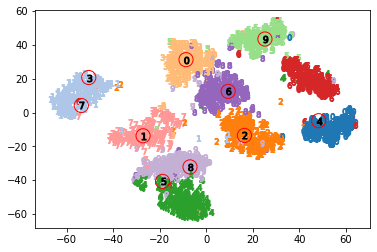

In [195]:
zs_g,ts_g,mus_g,logvars_g = take_latents(valid_loader,resnet_vae)
points = TSNE(n_components=2,random_state=0).fit_transform(mus_g.view(-1,CNN_embed_dim).cpu().detach().numpy())
data_points = points[0:take_latent_max*batch_size]
center_points = points[take_latent_max*batch_size:]
data_labels = ts_g[0:take_latent_max*batch_size].cpu().detach().numpy()
center_labels = (-ts_g[take_latent_max*batch_size:]-1).cpu().detach().numpy()
drawpoints_with_centers(data_points,data_labels,center_points,center_labels)

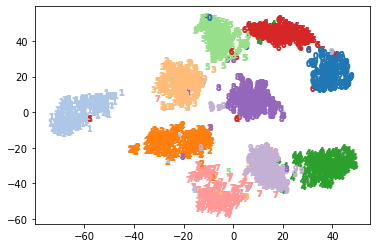

In [28]:
zs_g,ts_g,mus_g,logvars_g = take_latents_nocenter(valid_loader,resnet_vae)
points = TSNE(n_components=2,random_state=0).fit_transform(mus_g.view(-1,CNN_embed_dim).cpu().detach().numpy())
data_points = points[0:take_latent_max*batch_size]
data_labels = ts_g[0:take_latent_max*batch_size].cpu().detach().numpy()
drawpoints(data_points,data_labels)

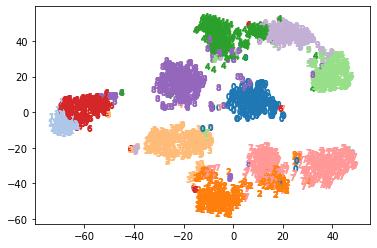

In [29]:
kmeans_model = KMeans(n_clusters=K_model_cluster, random_state=1).fit(mus_g.view(-1,CNN_embed_dim).cpu().detach().numpy())
drawpoints(data_points,kmeans_model.labels_[:take_latent_max*batch_size])

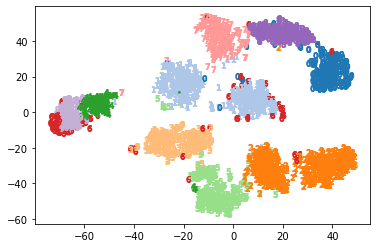

In [30]:
gauss_model = GaussianMixture(n_components=K_model_cluster,covariance_type='full',random_state=2,max_iter=100).fit(mus_g.view(-1,CNN_embed_dim).cpu().detach().numpy())
drawpoints(data_points,gauss_model.predict(mus_g.view(-1,CNN_embed_dim).cpu().detach().numpy())[:take_latent_max*batch_size])

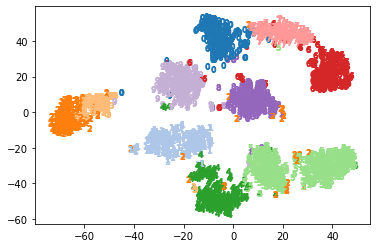

In [36]:
b_gauss_model = BayesianGaussianMixture(n_components=K_model_cluster,covariance_type='full',random_state=1,max_iter=1000,weight_concentration_prior=1.,weight_concentration_prior_type='dirichlet_process').fit(mus_g.view(-1,CNN_embed_dim).cpu().detach().numpy())
drawpoints(data_points,b_gauss_model.predict(mus_g.view(-1,CNN_embed_dim).cpu().detach().numpy())[:take_latent_max*batch_size])

In [37]:
mus_g.shape

torch.Size([2500, 10, 1])

In [ ]:
mus_g[0,:,0],logvars_g[0,:,0],zs_g[0,:,0],mu_c_g[0,:,0],logvar_c_g[0,:,0],log_N_k_g,log_N_k_g.exp().squeeze().sum()

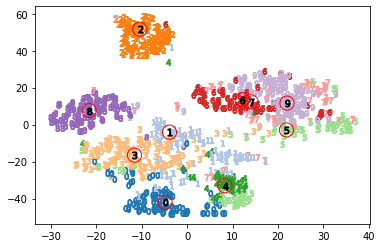

In [105]:
_,_,_,_,gamma_c_g,_ = gauss(mus_g[0:batch_size*take_latent_max,:,:],logvars_g,mu_c_g,logvar_c_g,log_N_k_g,1)
drawpoints_with_centers(data_points,torch.argmax(gamma_c_g,2).view(-1).cpu().detach().numpy(),center_points,center_labels)

In [106]:
mu_c_g[0,:,:],logvar_c_g[0,:,0]

(tensor([[-0.4187, -0.6087,  0.1049,  0.2525,  0.3237,  0.4298,  0.8273, -0.7228,
          -1.2732, -0.2685],
         [-1.7051, -0.2301,  1.6531, -0.1265, -0.1151, -0.9305, -0.2518, -0.4549,
          -0.4986,  0.8102],
         [-0.2234,  0.3093,  1.8915, -0.4255,  0.9474, -0.2545,  0.6591,  1.4320,
          -3.2193,  0.3509],
         [-0.5547,  1.5350,  1.9712, -0.7459, -2.0747, -3.4757,  1.4409,  0.9546,
           1.3617, -1.1312],
         [-5.1046, -0.6587,  2.8280, -1.1313, -0.8625, -2.1542,  1.0750, -0.8841,
          -0.8514,  1.4818],
         [ 0.7877,  0.9658,  0.9905,  3.7993, -0.7835, -0.3684, -2.7813, -1.8135,
           0.5726, -1.4408],
         [ 0.0792,  0.0545,  0.0985,  0.0635,  0.0991,  0.1055,  0.0871,  0.0935,
           0.1538,  0.0886],
         [ 1.4242, -0.8283,  1.3875,  0.4181,  0.1753, -0.5375,  0.3322,  0.0951,
           0.6980,  0.1580],
         [-0.8141, -1.9187, -1.3630, -0.6416, -3.4838,  0.2059,  1.1540,  0.6777,
          -1.9472,  1.9787],
 

In [107]:
show_generated_samples_c(mu_c=mu_c_g,logvar_c=logvar_c_g,model=resnet_vae)

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


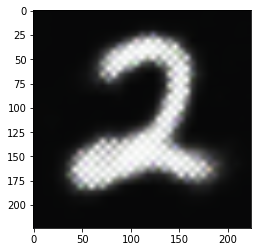

In [108]:
plt.imshow(resnet_vae.decode(mu_c_g.permute(2,1,0).squeeze())[8,:,:,:].permute(1,2,0).cpu().detach().numpy())

In [231]:
#optimizer.param_groups[0]['lr']=0.002,optimizer_clustering.param_groups[0]['lr']=0.002
optimizer.param_groups[0]['lr'],optimizer_clustering.param_groups[0]['lr'],beta

(0.0004782969, 0.0009565938, 192.0)

In [232]:
correspond_matrix = torch.zeros(K_real_cluster,K_model_cluster)

for i in range(batch_size*take_latent_max):

    for j in range(K_model_cluster):
        for k in range(K_real_cluster):
            if torch.argmax(gamma_c_g,2)[i,0] == j:
                if ts_g[i] == k:
                    correspond_matrix[k,j] +=1


In [233]:
correspond_matrix

tensor([[  0.,   0.,   0.,  85.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0., 124.,   0.,   1.,   0.,   1.,   0.,   0.,   0.],
        [  1.,   0.,   0.,   0.,   0.,   0., 113.,   2.,   0.,   0.],
        [  2., 103.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   1.,   0.,   0.,  75.,   0.,   0.,   1.,  33.],
        [  0.,  14.,   0.,   0.,  73.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   1.,   2.,   0.,   1.,   0.,  83.,   0.],
        [  0.,   0.,   1.,   0.,   0.,   4.,   1.,  92.,   0.,   1.],
        [ 79.,   6.,   0.,   0.,   1.,   2.,   0.,   0.,   1.,   0.],
        [  3.,   1.,   0.,   0.,   0.,  47.,   0.,   0.,   0.,  43.]])

In [234]:
correspond_matrix.sum()

tensor(1000.)

In [235]:
torch.max(correspond_matrix,0)

torch.return_types.max(
values=tensor([ 79., 103., 124.,  85.,  73.,  75., 113.,  92.,  83.,  43.]),
indices=tensor([8, 3, 1, 0, 5, 4, 2, 7, 6, 9]))

In [236]:
torch.max(correspond_matrix,0).values.sum()/(batch_size*take_latent_max)

tensor(0.8700)

In [237]:
log_N_k_g.exp().squeeze()

tensor([ 9.3555, 11.7969, 11.1207,  9.7413,  7.9480,  9.7269, 10.2635,  9.9264,
         9.6768, 10.0600], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [238]:

log_N_k_g.exp().squeeze().sum()

tensor(99.6159, device='cuda:0', grad_fn=<SumBackward0>)

In [239]:
affinity_mat = torch.zeros(K_model_cluster,K_model_cluster)
affinity_mat

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [240]:
for i in range(K_model_cluster):
    for j in range(K_model_cluster):
        if i!=j:
#            affinity_mat[i,j]= 1./((mu_c_g[0,:,i]-mu_c_g[0,:,j]).pow(2).sum())
            affinity_mat[i,j]= -(0.5*(((2*math.pi*(logvar_c_g[0,:,i].exp()+logvar_c_g[0,:,j].exp())).log()+(mu_c_g[0,:,i]-mu_c_g[0,:,j]).pow(2)/(logvar_c_g[0,:,i].exp()+logvar_c_g[0,:,j].exp())).sum()))
    for j in range(K_model_cluster):
        if i==j:
            affinity_mat[i,i]= torch.min(affinity_mat)


affinity_mat

tensor([[-32.4527, -26.2859, -32.2232, -30.6044, -28.6732, -29.6975, -28.3939,
         -32.4424, -32.4527, -27.9144],
        [-26.2859, -32.6717, -31.2979, -28.0838, -24.9882, -32.6717, -27.8235,
         -30.0705, -29.3298, -31.3801],
        [-32.2232, -31.2979, -34.6958, -34.6958, -32.1927, -29.4084, -30.0095,
         -30.6588, -33.2125, -29.6939],
        [-30.6044, -28.0838, -34.6958, -34.6958, -30.6083, -31.5349, -30.6704,
         -31.6670, -29.9180, -31.7911],
        [-28.6732, -24.9882, -32.1927, -30.6083, -34.6958, -31.1773, -33.7984,
         -31.5268, -28.4738, -30.4646],
        [-29.6975, -32.6717, -29.4084, -31.5349, -31.1773, -34.6958, -31.8548,
         -26.3971, -32.5869, -22.3274],
        [-28.3939, -27.8235, -30.0095, -30.6704, -33.7984, -31.8548, -34.6958,
         -29.9866, -30.4325, -32.5244],
        [-32.4424, -30.0705, -30.6588, -31.6670, -31.5268, -26.3971, -29.9866,
         -38.7085, -38.7085, -24.8675],
        [-32.4527, -29.3298, -33.2125, -29.9180,

In [241]:
index_mat = torch.arange(K_model_cluster)
index_row = torch.arange(K_model_cluster)

In [242]:
(i_c,j_c) = np.unravel_index(torch.argmax(affinity_mat),affinity_mat.shape)
for i in range(K_model_cluster):
    if index_row[i]==j_c:
        index_row[i]=i_c
index_mat = torch.cat((index_mat.view(-1,K_model_cluster),index_row.view(1,K_model_cluster)),0)
index_mat,i_c,j_c

(tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
         [0, 1, 2, 3, 4, 5, 6, 7, 8, 5]]),
 5,
 9)

In [243]:
affinity_mat[i_c,:]= torch.max(affinity_mat[i_c],affinity_mat[j_c])
#affinity_mat[i_c,:]= (0.5*(affinity_mat[i_c].exp()+affinity_mat[j_c].exp())).log()
affinity_mat[j_c,:]= torch.min(affinity_mat)
affinity_mat[:,j_c]= torch.min(affinity_mat)
affinity_mat[i_c,i_c]= torch.min(affinity_mat)
affinity_mat[:,i_c]= affinity_mat[i_c,:]
affinity_mat

tensor([[-32.4527, -26.2859, -32.2232, -30.6044, -28.6732, -27.9144, -28.3939,
         -32.4424, -32.4527, -38.7085],
        [-26.2859, -32.6717, -31.2979, -28.0838, -24.9882, -31.3801, -27.8235,
         -30.0705, -29.3298, -38.7085],
        [-32.2232, -31.2979, -34.6958, -34.6958, -32.1927, -29.4084, -30.0095,
         -30.6588, -33.2125, -38.7085],
        [-30.6044, -28.0838, -34.6958, -34.6958, -30.6083, -31.5349, -30.6704,
         -31.6670, -29.9180, -38.7085],
        [-28.6732, -24.9882, -32.1927, -30.6083, -34.6958, -30.4646, -33.7984,
         -31.5268, -28.4738, -38.7085],
        [-27.9144, -31.3801, -29.4084, -31.5349, -30.4646, -38.7085, -31.8548,
         -24.8675, -32.5869, -38.7085],
        [-28.3939, -27.8235, -30.0095, -30.6704, -33.7984, -31.8548, -34.6958,
         -29.9866, -30.4325, -38.7085],
        [-32.4424, -30.0705, -30.6588, -31.6670, -31.5268, -24.8675, -29.9866,
         -38.7085, -38.7085, -38.7085],
        [-32.4527, -29.3298, -33.2125, -29.9180,

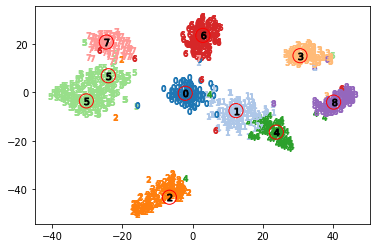

In [244]:
#_,_,_,_,gamma_c_g,_ = gauss(mus_g[0:batch_size*take_latent_max,:,:],logvars_g,mu_c_g,logvar_c_g,log_N_k_g,1)
drawpoints_with_centers(data_points,index_row[torch.argmax(gamma_c_g,2).view(-1).cpu().detach().numpy()],center_points,index_row)


In [40]:

take_latent_max=1200
zs_g,ts_g,mus_g,logvars_g = take_latents_nocenter(train_loader,resnet_vae)
data_folder = './gmm-resnet-results/data/'
np.save(os.path.join(data_folder, 'mus_g_N{}_L{}_ep{}_bs{}_res101.npy'.format(mus_g.shape[0],mus_g.shape[1],epochs,batch_size)), mus_g.cpu())
np.save(os.path.join(data_folder, 'ts_g_N{}_L{}_ep{}_bs{}_res101.npy'.format(ts_g.shape[0],mus_g.shape[1],epochs,batch_size)), ts_g.cpu())
np.save(os.path.join(data_folder, 'logvars_g_N{}_L{}_ep{}_bs{}_res101.npy'.format(logvars_g.shape[0],logvars_g.shape[1],epochs,batch_size)), logvars_g.cpu())

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


In [ ]:
mus_g = np.load('./gmm-resnet-results/data/mus_g_N2500_L5_ep150_bs50_res101.npy')
ts_g = np.load('./gmm-resnet-results/data/ts_g_N2500_ep150_bs50_res101.npy')


